<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_2_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC

* **Binary Classification** - Classification between two possibilities (positive and negative).  Common in medical testing, does the person have the disease (positive) or not (negative).
* **Classification** - Classification between more than 2.  The iris dataset (3-way classification).
* **Regression** - Numeric prediction.  How many MPG does a car get? (covered in next video)

In this class session we will look at some visualizations for all three.


It is important to evaluate the level of error in the results produced by a neural network.  In this part we will look at how to evaluate error for both classification and regression neural networks.

Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative".  Consider the following program that uses the [wcbreast_wdbc dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_wcbc.ipynb) to classify if a breast tumor is cancerous (malignant) or not (benign).  

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv",
    na_values=['NA','?'])

display(df[0:5])

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### ROC Curves

ROC curves can be a bit confusing.  However, they are very common.  It is important to know how to read them.  Even their name is confusing.  Do not worry about their name, it comes from electrical engineering (EE).

Binary classification is common in medical testing.  Often you want to diagnose if someone has a disease.  This can lead to two types of errors, know as false positives and false negatives:

* **False Positive** - Your test (neural network) indicated that the patient had the disease; however, the patient did not have the disease.
* **False Negative** - Your test (neural network) indicated that the patient did not have the disease; however, the patient did have the disease.
* **True Positive** - Your test (neural network) correctly identified that the patient had the disease.
* **True Negative** - Your test (neural network) correctly identified that the patient did not have the disease.

Types of errors:

![Type of Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_errors.png "Type of Error")

Neural networks classify in terms of probability of it being positive. However, at what probability do you give a positive result?  Is the cutoff 50%? 90%?  Where you set this cutoff is called the threshold.  Anything above the cutoff is positive, anything below is negative.  Setting this cutoff allows the model to be more sensitive or specific:

More info on Sensitivity vs Specificity: [Khan Academy](https://www.youtube.com/watch?v=Z5TtopYX1Gc)

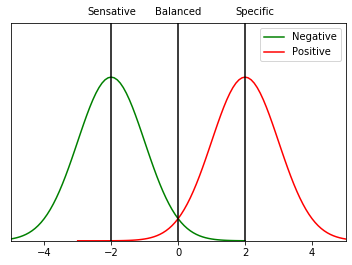

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu1 = -2
mu2 = 2
variance = 1
sigma = math.sqrt(variance)
x1 = np.linspace(mu1 - 5*sigma, mu1 + 4*sigma, 100)
x2 = np.linspace(mu2 - 5*sigma, mu2 + 4*sigma, 100)
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma)/1,color="green")
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma)/1,color="red")
plt.axvline(x=-2,color="black")
plt.axvline(x=0,color="black")
plt.axvline(x=+2,color="black")
plt.text(-2.7,0.55,"Sensative")
plt.text(-0.7,0.55,"Balanced")
plt.text(1.7,0.55,"Specific")
plt.ylim([0,0.53])
plt.xlim([-5,5])
plt.legend(['Negative','Positive'])
plt.yticks([])
#plt.set_yticklabels([])
plt.show()

In [3]:
from scipy.stats import zscore

# Prepare data - apply z-score to ALL x columns
# Only do this if you have no categoricals (and are sure you want to use z-score across the board)
x_columns = df.columns.drop('diagnosis').drop('id')
for col in x_columns:
    df[col] = zscore(df[col])

# Convert to numpy - Regression
x = df[x_columns].values
y = df['diagnosis'].map({'M':1,"B":0}).values # Binary classification, M is 1 and B is 0

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### ROC Chart Example

In [5]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(1,activation='linear',kernel_initializer='random_normal'))
model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
    patience=5, verbose=1, mode='auto', restore_best_weights=True)

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 426 samples, validate on 143 samples
Epoch 1/1000
426/426 - 2s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 2/1000
426/426 - 0s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 3/1000
426/426 - 0s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 4/1000
426/426 - 0s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 5/1000
426/426 - 0s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 6/1000
Restoring model weights from the end of the best epoch.
426/426 - 0s - loss: 5.7210 - accuracy: 0.6291 - val_loss: 5.8248 - val_accuracy: 0.6224
Epoch 00006: early stopping


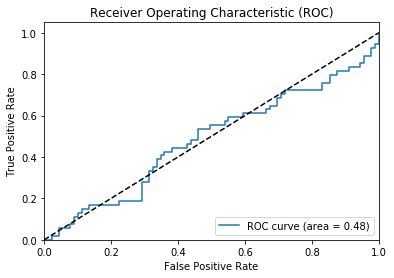

In [6]:
pred = model.predict(x_test)
plot_roc(pred,y_test)

### Multiclass Classification Error Metrics

The following sections will examine several metrics for evaluating classification error. The following classification neural network will be used to evaluate.

In [7]:
import pandas as pd
from scipy.stats import zscore

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('product').drop('id')
x = df[x_columns].values
dummies = pd.get_dummies(df['product']) # Classification
products = dummies.columns
y = dummies.values

In [8]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu',kernel_initializer='random_normal'))
model.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(Dense(y.shape[1],activation='softmax',kernel_initializer='random_normal'))
model.compile(loss='categorical_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 1500 samples, validate on 500 samples
Epoch 1/1000
1500/1500 - 1s - loss: 1.4479 - accuracy: 0.4067 - val_loss: 1.1188 - val_accuracy: 0.5040
Epoch 2/1000
1500/1500 - 0s - loss: 1.1299 - accuracy: 0.4627 - val_loss: 1.0855 - val_accuracy: 0.4720
Epoch 3/1000
1500/1500 - 0s - loss: 1.0783 - accuracy: 0.5047 - val_loss: 1.0324 - val_accuracy: 0.5200
Epoch 4/1000
1500/1500 - 0s - loss: 0.9767 - accuracy: 0.5733 - val_loss: 0.9607 - val_accuracy: 0.5440
Epoch 5/1000
1500/1500 - 0s - loss: 0.8638 - accuracy: 0.6340 - val_loss: 0.8446 - val_accuracy: 0.6780
Epoch 6/1000
1500/1500 - 0s - loss: 0.7972 - accuracy: 0.6820 - val_loss: 0.8344 - val_accuracy: 0.6500
Epoch 7/1000
1500/1500 - 0s - loss: 0.7667 - accuracy: 0.6753 - val_loss: 0.7984 - val_accuracy: 0.7020
Epoch 8/1000
1500/1500 - 0s - loss: 0.7495 - accuracy: 0.6780 - val_loss: 0.8347 - val_accuracy: 0.6400
Epoch 9/1000
1500/1500 - 0s - loss: 0.7376 - accuracy: 0.6860 - val_loss: 0.7714 - val_accuracy: 0.6680
Epoch 10/1000
150

### Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$ accuracy = \frac{c}{N} $

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual iris predicted with **argmax**.

In [9]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

Now that we have the actual iris flower predicted, we can calculate the percent accuracy (how many were correctly classified).

In [10]:
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.698


### Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:


In [11]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)

Numpy array of predictions


array([[0.    , 0.1065, 0.6795, 0.2134, 0.0007, 0.    , 0.    ],
       [0.    , 0.755 , 0.2437, 0.    , 0.0013, 0.    , 0.    ],
       [0.    , 0.7047, 0.2916, 0.0004, 0.0033, 0.    , 0.    ],
       [0.    , 0.3164, 0.6668, 0.0154, 0.0014, 0.    , 0.    ],
       [0.    , 0.0462, 0.5769, 0.3767, 0.0002, 0.    , 0.    ]],
      dtype=float32)

As percent probability
[ 0.     10.6481 67.9451 21.3382  0.0683  0.0003  0.    ]
Log loss score: 0.7310668326690793


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$ \mbox{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

C:\Users\jheaton\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


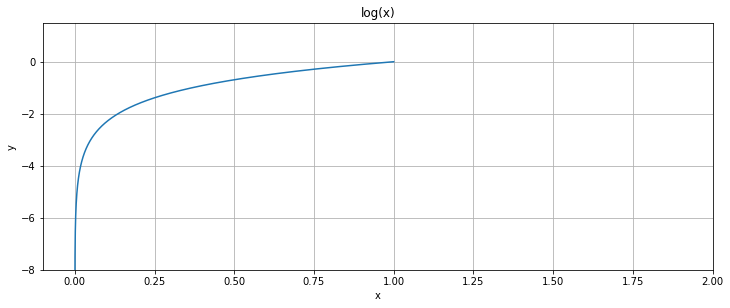

In [12]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

Confusion matrix, without normalization
[[ 21   1   0   0   0   0   0]
 [  4 190  54   1   0   0   0]
 [  0  51 129   7   0   0   0]
 [  0   0   5   9   0   0   0]
 [  0   8   0   0   0   0   0]
 [ 10   7   0   0   0   0   0]
 [  3   0   0   0   0   0   0]]
Normalized confusion matrix
[[0.95 0.05 0.   0.   0.   0.   0.  ]
 [0.02 0.76 0.22 0.   0.   0.   0.  ]
 [0.   0.27 0.69 0.04 0.   0.   0.  ]
 [0.   0.   0.36 0.64 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.59 0.41 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]]


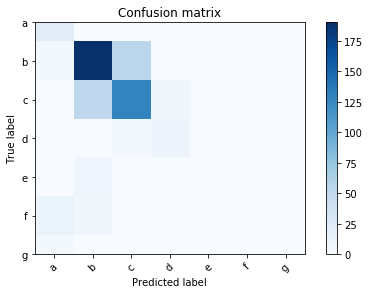

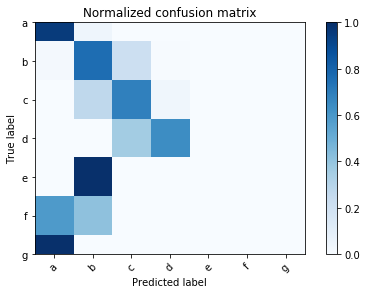

In [13]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()